<h1 style="text-align:center; color:dark

<h1 style="text-align:center; color:darkgreen"> IBM Data Science Professional Certificate </h1>
<h2 style="text-align:center; color:darkgreen"> Capstone Project: Battle of Neighborhoods </h2> 
<a href="https://www.coursera.org/specializations/ibm-data-science-professional-certificate" target="_blank"><p style="text-align:center; font-size:8; color:darkgray"> Applied Data Science by Coursera/ IBM </p></a>


<br>

<img src="https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwiy77_k_-jhAhXQzqQKHca9DfkQjRx6BAgBEAU&url=https%3A%2F%2Fwww.amazon.com%2FWall-Art-Prints-Toronto-Landscape%2Fdp%2FB07JHWJMSF&psig=AOvVaw2FMUPh42FBonkUcz-JLmXw&ust=1556204156505945" height=500 width=700>

<br>
<br>

### Jupyter Notebook (including all code) - Note that the report is provided separately!

We will start by importing the libraries we will need to work in this Notebook. 
<br>

In [1]:
#importing all libraries

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import lxml.html as lh
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
print('Folium installed')
print('Libraries imported.')

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

<br>

## Data acquiring and processing

<br>

### Web Scraping using Beautiful Soup
<br>

We will use web scraping to the following wikipedia page "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" (we will try to retrieve the rows that contains data)

In [78]:
#Scraping Wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)

soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find('table')
trows = table.find_all('tr')
rows = []
for tr in trows:
    i = tr.find_all('td')
    if i:
        rows.append(i)        
lst = []
for row in rows:
    postalcode = row[0].text.rstrip()
    borough = row[1].text.rstrip()
    neighborhood = row[2].text.rstrip()
    if borough != 'Not assigned':
        if neighborhood == 'Not assigned':
            neighborhood = borough
        lst.append([postalcode, borough, neighborhood])
        
cols = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(lst, columns=cols)
print(df.shape)

(211, 3)


In [79]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Note: the retrieved dataset contains data that are duplicate. So we will clean this by using *".groupby"* to keep the first Borough and *".join()"* the Neighborhoods

In [3]:
#Cleaning data

#groupby PostalCode, keep the first Borough and join() Neighborhoods
df = df.groupby('PostalCode').agg(
    {
        'Borough':'first', 
        'Neighborhood': ', '.join,}
    ).reset_index()

df.shape

(103, 3)

The size now looks fine. Let's run a test to see if we have the dataset how we wanted it to be.

In [4]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Yes! that's fine.

In order to visualize the neighborhoods of the city of Toronto, we need the geospatial data of each neighborhoods. We have collected data from *http://cocl.us/Geospatial_data* and the population counts from *https://www.statcan.gc.ca* <br>
We have converted the *.csv* files into *pandas data frame*

In [5]:
#Clean and sort
#read the csv and put it into pandas data frame
dfgeo = pd.read_csv("Geospatial.csv")
dfgeo.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df2 = pd.merge(df, dfgeo, on="PostalCode", how='left')
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383


In [6]:
#df2: how many boroughs and neighborhoods are there?

print('The dataframe (2) has {} boroughs and {} neighborhoods.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe (2) has 11 boroughs and 103 neighborhoods.


<h5> Geographical coordinates of Toronto </h5>

In [7]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


##### Creating map of Toronto using latitude and longitude values

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Foursquare - set up

In [9]:
#Foursquare credentials
CLIENT_ID = 'hidden' # your Foursquare ID
CLIENT_SECRET = 'hidden' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

As described earlier, we will set the limit of the parameters: API call of each neighborhood and radius.

In [ ]:
#set the limit
LIMIT = 100
radius = 700

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

In [ ]:
#@hidden cell

In [11]:
results = requests.get(url).json()
#results

In [12]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

Now that we have acquired the venues of each neighborhod, let's define a function to get the *venue names* with *venue categories*

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Textile Museum of Canada,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",43.654396,-79.386500
2,Japango,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",43.655268,-79.385165
3,Sansotei Ramen 三草亭,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",43.655157,-79.386501
4,Tsujiri,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.655374,-79.385354


Well, that doesn't look optimal for further use! So we use *".apply()"* to get the type of the categories.

In [15]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Textile Museum of Canada,Art Museum,43.654396,-79.386500
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Tsujiri,Tea Room,43.655374,-79.385354


Let's create a function to repeat the same process to all neighborhoods in the city of Toronto

In [16]:
#let's create a function to repeat the same process to all neighborhoods in Toronto, CA

def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

<br>
We will look at the size

In [18]:
print(toronto_venues.shape)

(3442, 7)


In [19]:
toronto_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,10,10,10,10,10,10
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",13,13,13,13,13,13
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Downsview North, Wilson Heights",21,21,21,21,21,21
Bayview Village,9,9,9,9,9,9
"Bedford Park, Lawrence Manor East",31,31,31,31,31,31
Berczy Park,100,100,100,100,100,100


How many unique categories are there?

In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 321 uniques categories.


### One Hot Encoding

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Rest

In [22]:
toronto_onehot.shape

(3442, 321)

In [23]:
#here we group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Rest

##### New size after "one hot encoding"

In [24]:
#the new size

toronto_grouped.shape

(102, 321)

In [25]:
#save the data (totally optional)

toronto_grouped.to_csv('toronto_grouped.csv', sep='\t')


**Let's find out each neighborhood along with the top 10 most common venues**

In [26]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood'][:5]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2  American Restaurant  0.04
3           Steakhouse  0.04
4            Gastropub  0.03
5                  Bar  0.03
6              Theater  0.03
7           Restaurant  0.03
8     Sushi Restaurant  0.03
9      Thai Restaurant  0.03


----Agincourt----
                 venue  freq
0      Motorcycle Shop   0.1
1          Coffee Shop   0.1
2       Sandwich Place   0.1
3         Skating Rink   0.1
4               Lounge   0.1
5  Shanghai Restaurant   0.1
6       Clothing Store   0.1
7      Badminton Court   0.1
8       Breakfast Spot   0.1
9            Pool Hall   0.1


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0           Pizza Place  0.15
1              Pharmacy  0.15
2          Noodle House  0.08
3                  Park  0.08
4      Malay Restaurant  0.08
5        Shop & Service  0.08
6             BBQ Joint  0.08
7 

### Let's put it into pandas Dataframe

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
#create a new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Gastropub,Hotel,Bar,Sushi Restaurant,Restaurant,Thai Restaurant
1,Agincourt,Motorcycle Shop,Coffee Shop,Badminton Court,Clothing Store,Lounge,Pool Hall,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Skating Rink
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Pizza Place,BBQ Joint,Caribbean Restaurant,Gym,Malay Restaurant,Park,Fast Food Restaurant,Shop & Service,Chinese Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Hardware Store,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Sandwich Place,Pizza Place,Pharmacy,Colombian Restaurant,Drugstore
4,"Alderwood, Long Branch",Pizza Place,Pool,Convenience Store,Gas Station,Skating Rink,Pub,Sandwich Place,Gym,Coffee Shop,Pharmacy
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Chinese Restaurant,Community Center,Sandwich Place,Sushi Restaurant,Supermarket,Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Diner
6,Bayview Village,Bank,Skate Park,Skating Rink,Japanese Restaurant,Restaurant,Chinese Restaurant,Café,Grocery Store,Dumpling Restaurant,Drugstore
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sushi Restaurant,Fast Food Restaurant,Toy / Game Store,Bakery,Bagel Shop,Butcher,Indian Restaurant,Restaurant
8,Berczy Park,Coffee Shop,Hotel,Café,Restaurant,Park,Cocktail Bar,Beer Bar,Seafood Restaurant,Cosmetics Shop,Bakery
9,"Birch Cliff, Cliffside West",College Stadium,Bank,Café,Diner,Discount Store,General Entertainment,Skating Rink,Park,Thai Restaurant,Eastern European Restaurant


<br>

## Clustering Neighborhoods
<br>

Determining the optimal number of clusters in a data set is a fundamental issue in partitioning clustering, such as **k-means clustering**, which requires the user to specify the number of clusters k to be generated.<br>

There are many methods to determine the optimal number. These methods include **direct methods** and **statistical testing methods**. <br>

In this project we will consider the direct methods. We will use **Elbow** method and **Average Silhouette** method.
<br>

In [29]:
# import libraries

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

##### Elbow Method

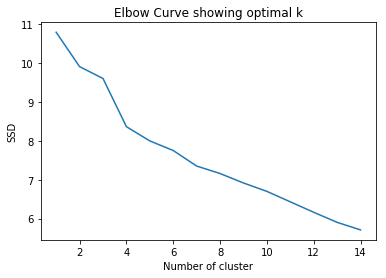

In [30]:
toronto_clustering = toronto_grouped.drop('Neighborhood', 1)
ssd={}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(toronto_clustering)
    ssd[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(ssd.keys()), list(ssd.values()))
plt.title("Elbow Curve showing optimal k")
plt.xlabel("Number of cluster")
plt.ylabel("SSD")
plt.show()

##### Average Silhouette Method

For 3  Clusters  the average silhouette_score is : 0.29448380956963743
For 4  Clusters  the average silhouette_score is : 0.2826154212630466
For 5  Clusters  the average silhouette_score is : 0.15425282149540875
For 10  Clusters  the average silhouette_score is : 0.19178501701668618
For 12  Clusters  the average silhouette_score is : 0.11137974895160209


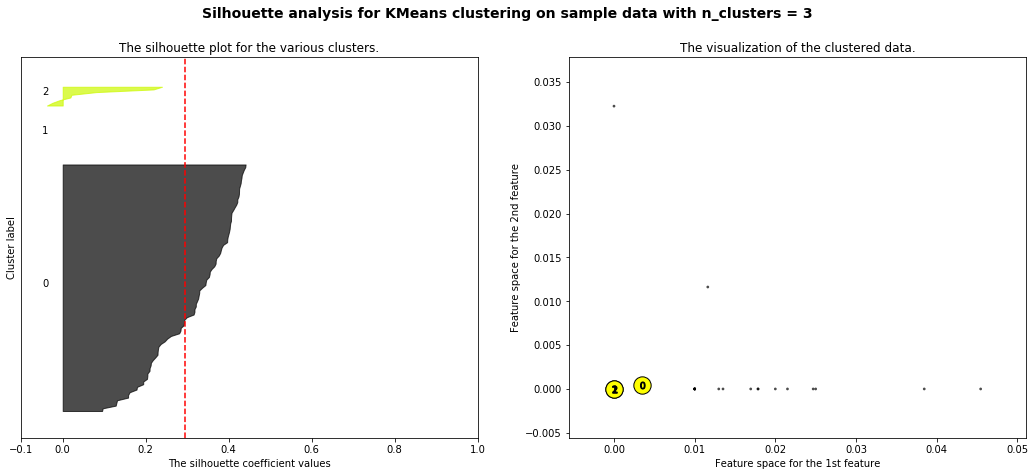

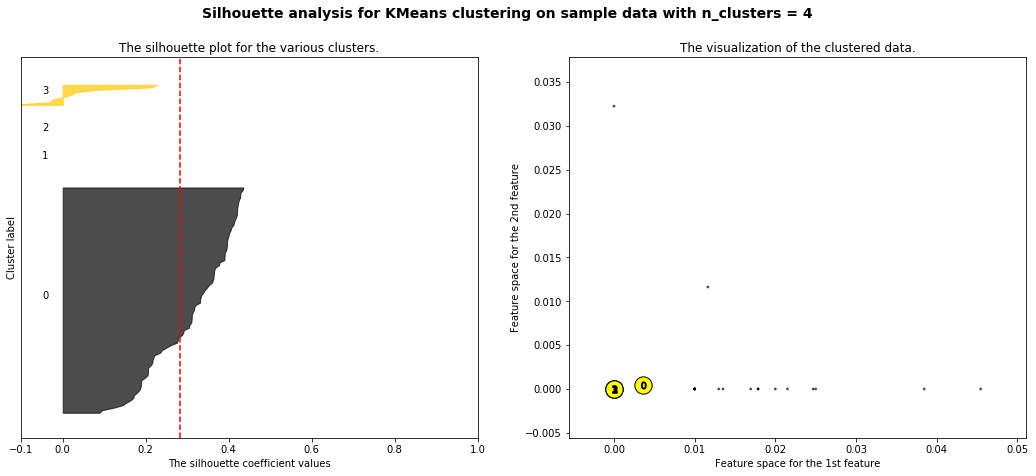

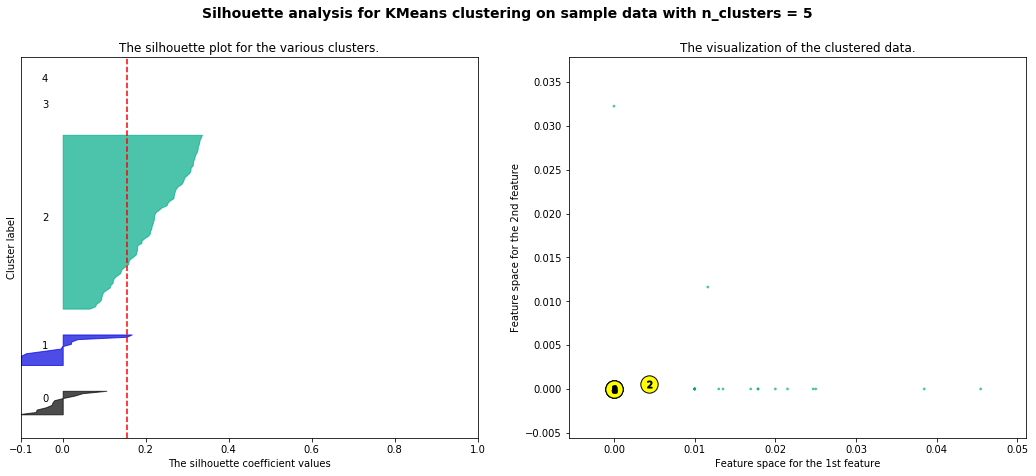

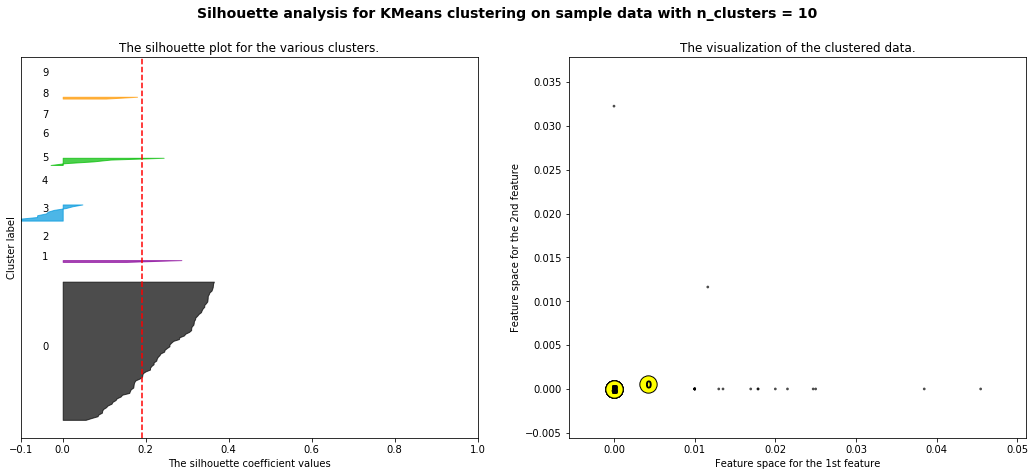

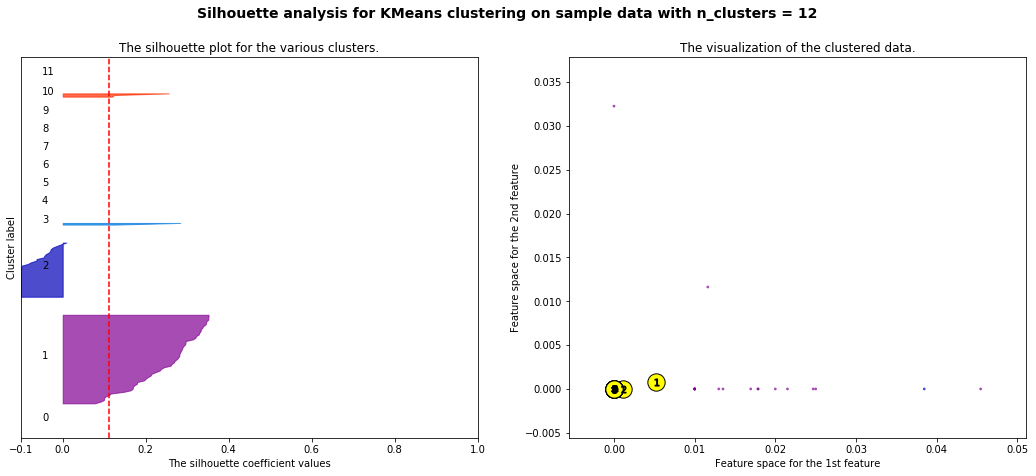

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters=[3,4,5,10,12]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(toronto_clustering) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(toronto_clustering)
    silhouette_avg = silhouette_score(toronto_clustering, cluster_labels)
    print("For", n_clusters, " Clusters  "
          "the average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(toronto_clustering, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color1 = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color1, edgecolor=color1, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors2 = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(toronto_clustering.iloc[:, 0], toronto_clustering.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="yellow", alpha=1, s=300, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

<br>
<br>

In [32]:
# set number of clusters
kclusters = 5

toronto_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 0, 0, 2, 2, 2, 2, 2], dtype=int32)

In [33]:
k_means_cluster_centers = kmeans.cluster_centers_
k_means_cluster_centers

array([[ 1.30104261e-18, -1.08420217e-19, -2.16840434e-19, ...,
        -4.33680869e-19, -8.67361738e-19,  4.27350427e-03],
       [ 0.00000000e+00, -5.42101086e-20,  0.00000000e+00, ...,
        -2.16840434e-19,  8.33333333e-02,  0.00000000e+00],
       [ 4.52645403e-03,  6.09527382e-04,  9.41669784e-04, ...,
         2.31481481e-03,  3.43812610e-03,  4.97121926e-04],
       [ 0.00000000e+00,  5.42101086e-20,  0.00000000e+00, ...,
         2.16840434e-19,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

##### Adding the cluster labels

In [34]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df2
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,2.0,Fast Food Restaurant,Coffee Shop,Spa,Hobby Shop,Bus Station,Women's Store,Drugstore,Diner,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626,2.0,Breakfast Spot,Bar,Burger Joint,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,0.0,Fast Food Restaurant,Pizza Place,Medical Center,Thrift / Vintage Store,Mexican Restaurant,Fried Chicken Joint,Electronics Store,Beer Store,Sports Bar,Moving Target
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690,3.0,Coffee Shop,Park,Business Service,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383,2.0,Bakery,Coffee Shop,Indian Restaurant,Hakka Restaurant,Chinese Restaurant,Flower Shop,Bank,Fried Chicken Joint,Thai Restaurant,Athletics & Sports


#### Creating map of neighborhoods with their cluster labels

In [35]:
# creating map - all the boroughs are now with claster labels 
import folium
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=10)
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']


### Examine the clusters

In [36]:
#Examine
#Cluster 1

df3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df3

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,46943,0.0,Fast Food Restaurant,Pizza Place,Medical Center,Thrift / Vintage Store,Mexican Restaurant,Fried Chicken Joint,Electronics Store,Beer Store,Sports Bar,Moving Target
5,Scarborough,36699,0.0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Dumpling Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
13,Scarborough,34588,0.0,Pharmacy,Pizza Place,Intersection,Fried Chicken Joint,Chinese Restaurant,Noodle House,Sandwich Place,Bus Stop,Seafood Restaurant,Shopping Mall
14,Scarborough,54680,0.0,Pharmacy,Pizza Place,BBQ Joint,Caribbean Restaurant,Gym,Malay Restaurant,Park,Fast Food Restaurant,Shop & Service,Chinese Restaurant
15,Scarborough,48471,0.0,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Electronics Store,Other Great Outdoors,American Restaurant,Breakfast Spot,Coffee Shop,Grocery Store,Pizza Place
24,North York,40792,0.0,Coffee Shop,Pizza Place,Grocery Store,Pharmacy,Women's Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
31,North York,17339,0.0,Pizza Place,Coffee Shop,Vietnamese Restaurant,Grocery Store,Park,Bank,Shopping Mall,Doner Restaurant,Dim Sum Restaurant,Diner
32,North York,24046,0.0,Baseball Field,Market,Pharmacy,Vietnamese Restaurant,Home Service,Women's Store,Diner,Discount Store,Dive Bar,Dog Run
33,North York,41958,0.0,Fast Food Restaurant,Athletics & Sports,Sandwich Place,Discount Store,Falafel Restaurant,Liquor Store,Fried Chicken Joint,Pizza Place,Grocery Store,Gym / Fitness Center
35,East York,18628,0.0,Pizza Place,Fast Food Restaurant,Café,Gym / Fitness Center,Pharmacy,Brewery,Intersection,Bank,Athletics & Sports,Pub


In [37]:
#Examine
#Cluster 2

df4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df4

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Scarborough,22913,1.0,Wings Joint,Chinese Restaurant,Furniture / Home Store,Burger Joint,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
17,North York,24497,1.0,Chinese Restaurant,Diner,Bakery,Housing Development,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
96,North York,11950,1.0,Bakery,Arts & Crafts Store,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


In [38]:
#Examine
#Cluster 3

df5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df5

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,66108,2.0,Fast Food Restaurant,Coffee Shop,Spa,Hobby Shop,Bus Station,Women's Store,Drugstore,Diner,Discount Store,Dive Bar
1,Scarborough,35626,2.0,Breakfast Spot,Bar,Burger Joint,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,Scarborough,24383,2.0,Bakery,Coffee Shop,Indian Restaurant,Hakka Restaurant,Chinese Restaurant,Flower Shop,Bank,Fried Chicken Joint,Thai Restaurant,Athletics & Sports
6,Scarborough,48434,2.0,Coffee Shop,Discount Store,Sandwich Place,Intersection,Grocery Store,Metro Station,Department Store,Convenience Store,Light Rail Station,Bus Station
7,Scarborough,35081,2.0,Intersection,Coffee Shop,Diner,Bakery,Bus Line,Fast Food Restaurant,Park,Metro Station,Soccer Field,Convenience Store
9,Scarborough,22136,2.0,College Stadium,Bank,Café,Diner,Discount Store,General Entertainment,Skating Rink,Park,Thai Restaurant,Eastern European Restaurant
10,Scarborough,45571,2.0,Indian Restaurant,Electronics Store,Bakery,Gym / Fitness Center,Wings Joint,Fast Food Restaurant,Vietnamese Restaurant,Pet Store,Coffee Shop,Chinese Restaurant
11,Scarborough,29858,2.0,Burger Joint,Coffee Shop,Intersection,Convenience Store,Rental Car Location,Seafood Restaurant,Middle Eastern Restaurant,Breakfast Spot,Fish Market,Korean Restaurant
12,Scarborough,37769,2.0,Motorcycle Shop,Coffee Shop,Badminton Court,Clothing Store,Lounge,Pool Hall,Breakfast Spot,Shanghai Restaurant,Sandwich Place,Skating Rink
18,North York,58293,2.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Baseball Field,Japanese Restaurant,Park,Cosmetics Shop,Restaurant,Food Court


In [39]:
#Examine
#Cluster 4

df6=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df6

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Scarborough,29690,3.0,Coffee Shop,Park,Business Service,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
21,North York,32320,3.0,Park,Coffee Shop,Trail,Women's Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
25,North York,34615,3.0,Park,Food & Drink Shop,Fast Food Restaurant,Pet Store,Burger Joint,Women's Store,Diner,Discount Store,Dive Bar,Dog Run
30,North York,5997,3.0,Sandwich Place,Coffee Shop,Airport,Park,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
44,Central Toronto,15330,3.0,Swim School,Business Service,Bus Line,Park,Women's Store,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
48,Central Toronto,10463,3.0,Park,Thai Restaurant,Playground,Gym,Grocery Store,Bank,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner
50,Downtown Toronto,14561,3.0,Park,Playground,Moving Target,Trail,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
64,Central Toronto,19423,3.0,Sushi Restaurant,Jewelry Store,Park,Trail,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run


In [40]:
#Examine
#Cluster 5

df7=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df7

,Borough,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,11717,4.0,Cafeteria,College Rec Center,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore


#### Creating the table containing all boroughs with cluster label for comparison

In [41]:
#creating cluster table
cluster_t=pd.DataFrame({"Cluster1":df3["Borough"],
                      "Cluster2":df4["Borough"],
                      "Cluster3":df5["Borough"],
                      "Cluster4":df6["Borough"],
                      "Cluster5":df7["Borough"]
                      })

In [42]:
cluster_t = cluster_t.replace(np.nan, '', regex=True)
cluster_t

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
0,,,Scarborough,,
1,,,Scarborough,,
2,Scarborough,,,,
3,,,,Scarborough,
4,,,Scarborough,,
5,Scarborough,,,,
6,,,Scarborough,,
7,,,Scarborough,,
8,,Scarborough,,,
9,,,Scarborough,,


In [43]:
new_toronto=toronto_merged.set_index("Neighborhood",drop=True)
new_toronto.head(10)

,PostalCode,Borough,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,
"Rouge, Malvern",M1B,Scarborough,43.806686,-79.194353,66108,2.0,Fast Food Restaurant,Coffee Shop,Spa,Hobby Shop,Bus Station,Women's Store,Drugstore,Diner,Discount Store,Dive Bar
"Highland Creek, Rouge Hill, Port Union",M1C,Scarborough,43.784535,-79.160497,35626,2.0,Breakfast Spot,Bar,Burger Joint,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
"Guildwood, Morningside, West Hill",M1E,Scarborough,43.763573,-79.188711,46943,0.0,Fast Food Restaurant,Pizza Place,Medical Center,Thrift / Vintage Store,Mexican Restaurant,Fried Chicken Joint,Electronics Store,Beer Store,Sports Bar,Moving Target
Woburn,M1G,Scarborough,43.770992,-79.216917,29690,3.0,Coffee Shop,Park,Business Service,Convenience Store,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
Cedarbrae,M1H,Scarborough,43.773136,-79.239476,24383,2.0,Bakery,Coffee Shop,Indian Restaurant,Hakka Restaurant,Chinese Restaurant,Flower Shop,Bank,Fried Chicken Joint,Thai Restaurant,Athletics & Sports
Scarborough Village,M1J,Scarborough,43.744734,-79.239476,36699,0.0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Dumpling Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
"East Birchmount Park, Ionview, Kennedy Park",M1K,Scarborough,43.727929,-79.262029,48434,2.0,Coffee Shop,Discount Store,Sandwich Place,Intersection,Grocery Store,Metro Station,Department Store,Convenience Store,Light Rail Station,Bus Station
"Clairlea, Golden Mile, Oakridge",M1L,Scarborough,43.711112,-79.284577,35081,2.0,Intersection,Coffee Shop,Diner,Bakery,Bus Line,Fast Food Restaurant,Park,Metro Station,Soccer Field,Convenience Store
"Cliffcrest, Cliffside, Scarborough Village West",M1M,Scarborough,43.716316,-79.239476,22913,1.0,Wings Joint,Chinese Restaurant,Furniture / Home Store,Burger Joint,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


In [44]:
new_toronto.tail(10)

,PostalCode,Borough,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,
Islington Avenue,M9A,Etobicoke,43.667856,-79.532242,35594,0.0,Pharmacy,Playground,Park,Skating Rink,Shopping Mall,Bank,Café,Grocery Store,Colombian Restaurant,Dog Run
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",M9B,Etobicoke,43.650943,-79.554724,32400,0.0,Pizza Place,Theater,Convenience Store,Bank,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",M9C,Etobicoke,43.643515,-79.577201,38291,0.0,Park,Café,Beer Store,Electronics Store,Liquor Store,Convenience Store,Pizza Place,Pharmacy,Event Space,Donut Shop
Humber Summit,M9L,North York,43.756303,-79.565963,11950,1.0,Bakery,Arts & Crafts Store,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
"Emery, Humberlea",M9M,North York,43.724766,-79.532242,22263,2.0,Convenience Store,Home Service,Discount Store,Baseball Field,Italian Restaurant,Paper / Office Supplies Store,Furniture / Home Store,Eastern European Restaurant,Electronics Store,Dumpling Restaurant
Weston,M9N,York,43.706876,-79.518188,25074,0.0,Convenience Store,Diner,Fried Chicken Joint,Pharmacy,Breakfast Spot,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant
Westmount,M9P,Etobicoke,43.696319,-79.532242,20874,2.0,Pizza Place,Intersection,Coffee Shop,Golf Driving Range,Golf Course,Middle Eastern Restaurant,Discount Store,Sandwich Place,Chinese Restaurant,Supermarket
"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",M9R,Etobicoke,43.688905,-79.554724,33743,0.0,Coffee Shop,Intersection,Chinese Restaurant,Sandwich Place,Mobile Phone Shop,Shopping Mall,Pharmacy,Beer Store,Supermarket,Bank
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",M9V,Etobicoke,43.739416,-79.588437,55959,0.0,Grocery Store,Hardware Store,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Sandwich Place,Pizza Place,Pharmacy,Colombian Restaurant,Drugstore


<br>

## Compare the neighborhoods

In [66]:
Nbd1=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Rosedale


In [68]:
Nbd2=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Westmount


In [69]:
venue_comparison=new_toronto.loc[[Nbd1,Nbd2]].T
venue_comparison

Neighborhood,Rosedale,Westmount
PostalCode,M4W,M9P
Borough,Downtown Toronto,Etobicoke
Latitude,43.6796,43.6963
Longitude,-79.3775,-79.5322
Population,14561,20874
Cluster Labels,3,2
1st Most Common Venue,Park,Pizza Place
2nd Most Common Venue,Playground,Intersection
3rd Most Common Venue,Moving Target,Coffee Shop
4th Most Common Venue,Trail,Golf Driving Range


In [70]:
Nbd1=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Rosedale


In [71]:
Nbd2=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Woburn


In [74]:
Nbd3=input("Enter the Neighborhood: ")

Enter the Neighborhood:  Humber Summit


In [75]:
venue_comparison=new_toronto.loc[[Nbd1,Nbd2,Nbd3]].T
venue_comparison

Neighborhood,Rosedale,Woburn,Humber Summit
PostalCode,M4W,M1G,M9L
Borough,Downtown Toronto,Scarborough,North York
Latitude,43.6796,43.771,43.7563
Longitude,-79.3775,-79.2169,-79.566
Population,14561,29690,11950
Cluster Labels,3,3,1
1st Most Common Venue,Park,Coffee Shop,Bakery
2nd Most Common Venue,Playground,Park,Arts & Crafts Store
3rd Most Common Venue,Moving Target,Business Service,Women's Store
4th Most Common Venue,Trail,Convenience Store,Drugstore


<br>
<br>